In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os

# import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.formula.api as smf

In [58]:
actors = pd.read_pickle("./data/actors.pkl")
movies = pd.read_pickle("./data/movies.pkl").set_index('IMDb_ID')

actors_movies = actors.droplevel(0, axis=1).merge(movies['averageRating'],left_on='IMDb_ID', right_index=True)
actors_movies = actors_movies.drop(columns=['birthYear', 'movie_count_genre'])
actors_movies = actors_movies.replace("\\N", pd.NA)

In [59]:
# Input:
#   - year (int)
#   - range (int)
# Output:
#   - Range (str)
def create_range(year, range=10):
    start_range = (year // range) * range
    return "{} - {}".format(start_range, start_range + range)


actors_movies = actors_movies.sort_values(by='Movie release date')
actors_movies['ReleaseYearRange'] = actors_movies['Movie release date'].apply(lambda x: create_range(x))


In [60]:
display(actors_movies)

,,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,awards,nominations,movie_count,genres_b4,IsDrama,isMale,age_at_release,averageRating,ReleaseYearRange
IMDb_ID,IMDb_actor_ID,,,,,,,,,,,,,,
tt0021061,nm0642988,1,24383800,Let's Go Native,1930,Jack Oakie,0,0,1,2,0,1,27,5.8,1930 - 1940
tt0021324,nm0000802,1,5884622,The Runaway Bride,1930,Mary Astor,0,0,1,7,0,0,24,4.9,1930 - 1940
tt0021233,nm0823597,1,32828818,Pardon My Gun,1930,Sally Starr,0,0,1,1,0,0,21,4.3,1930 - 1940
tt0020690,nm0002001,1,142837,The Big Pond,1930,Maurice Chevalier,0,1,1,7,0,1,42,5.7,1930 - 1940
tt0020806,nm0938464,1,2134118,Danger Lights,1930,Louis Wolheim,0,0,1,1,1,1,50,6.1,1930 - 1940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt2126282,nm3070408,1,31656709,Ekk Deewana Tha,2012,Prateik Patil Babbar,0,0,1,6,1,<NA>,26,6.1,2010 - 2020
tt2351177,nm3054665,1,35279558,Bhooter Bhabishyat,2012,Swastika Mukherjee,0,0,1,1,0,0,32,8.1,2010 - 2020
tt1623288,nm2240346,1,31804949,ParaNorman,2012,Kodi Smit-McPhee,0,0,2,7,0,1,16,7.0,2010 - 2020


SyntaxError: invalid syntax (<unknown>, line 1)

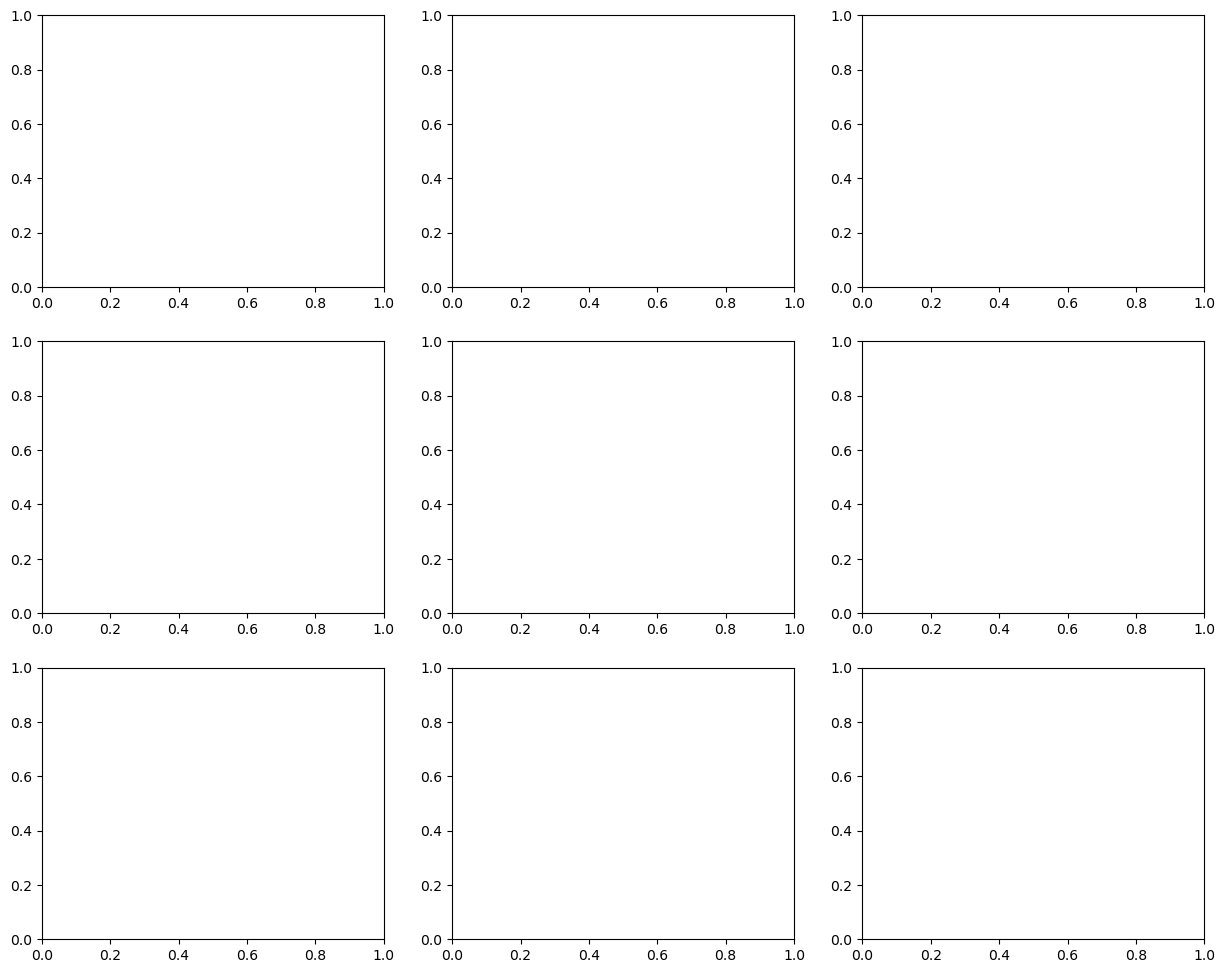

In [61]:
def do_fancy_ecpi_cute_plot(df, cat, diff, x, y_list, titles, ncols=3, max_y_ticks=5):

    nrows = -(-len(y_list) // ncols)  # Ceiling division to determine number of rows

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

    df = df.replace("\\N", pd.NA)

    lo = df.query(f'{diff} < @{cat}').copy()
    hi = df.query(f'{diff} >= @{cat}').copy()
    me = df.copy()
    
    lo.loc[:, 'Category'] = 'bellow {}'.format(globals()[cat])
    hi.loc[:, 'Category'] = 'above {}'.format(globals()[cat])
    me.loc[:, 'Category'] = 'mean'

    for i, (y, title) in enumerate(zip(y_list, titles)):

        lo_filtered = lo[lo[y].notna()]
        hi_filtered = hi[hi[y].notna()]
        me_filtered = me[me[y].notna()]

        lo_filtered.loc[:, y] = pd.to_numeric(lo_filtered[y])
        hi_filtered.loc[:, y] = pd.to_numeric(hi_filtered[y])
        me_filtered.loc[:, y] = pd.to_numeric(me_filtered[y])
        
        lo_filtered_mean = lo_filtered.groupby(x)[y].mean().reset_index()
        lo_filtered_mean['Category'] = 'bellow {}'.format(globals()[cat])

        hi_filtered_mean = hi_filtered.groupby(x)[y].mean().reset_index()
        hi_filtered_mean['Category'] = 'above {}'.format(globals()[cat])

        me_filtered_mean = me_filtered.groupby(x)[y].mean().reset_index()
        me_filtered_mean['Category'] = 'mean'

        frame = pd.concat([lo_filtered, hi_filtered, me_filtered])
        frame_mean = pd.concat([lo_filtered_mean, hi_filtered_mean, me_filtered_mean])
    
        ax = axes[i // ncols, i % ncols]
        sns.lineplot(data=frame, x=x, y=y, hue='Category', errorbar='ci', palette='viridis', ax=ax)
        sns.scatterplot(data=frame_mean, x=x, y=y, hue='Category', palette='viridis', ax=ax, legend=False, marker='o', s=30)
        ax.set_title(title)
        ax.legend(title='Category')

        # Rotate x-axis labels
        for label in ax.get_xticklabels():
            label.set_rotation(90)

        # Set y-axis tick frequency
        ax.yaxis.set_major_locator(MaxNLocator(nbins=max_y_ticks))
    

    # Turn off any unused subplots
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')

    plt.tight_layout()
    plt.show()

do_fancy_ecpi_cute_plot(actors_movies, 6.2, 'averageRating', 'ReleaseYearRange', 
                        ['birthYear', 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release'], 
                        ['birthYear', 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release'])

TODO: Add T-tests pour certains trucs par année, p.e en 1950-1960, p= 0.03 entre good grades et bad grades -> significant

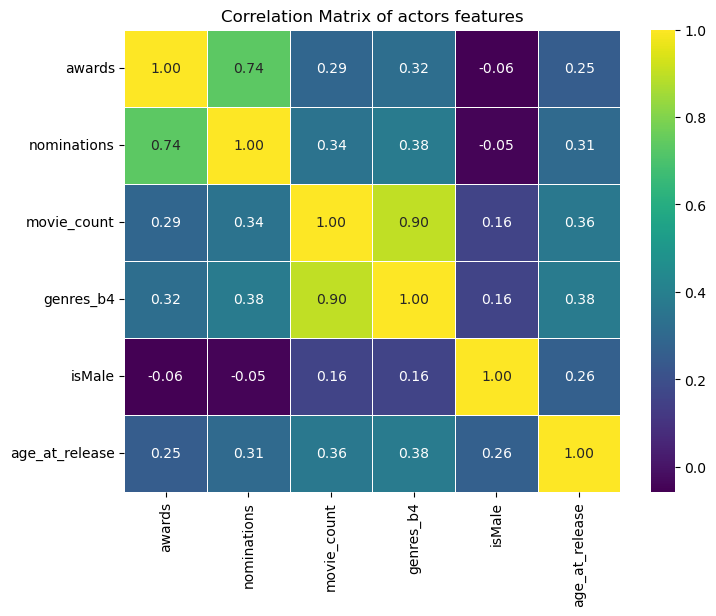

In [65]:
# Calculate the correlation matrix
correlation_matrix = actors_movies[['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix of actors features')
plt.show()

**Very high positive correlations**
- movie_count and genres_b4 exhibit a very high positive correlation (0.90). This indicates that actors who have a higher count of movies are also likely to have a high diversity of genres. It suggests that prolific actors have a significant presence in many genres.

**High positive correlations**
- awards and nominations have a strong positive correlation (0.74). This suggests that actors with more nominations tend to have more awards.

**Moderate Positive Correlations**
- movie_count has moderate positive correlations with nominations (0.34) and genres_b4 (0.38). This could imply that actors with a larger number of movies have slightly more nominations and diversity of genres.
- age_at_release also has a moderate positive correlation with genres_b4 (0.38), nominations (0.31) which might indicate that actors tend to have played in more genres and be more nominated as actors get older.

**Weak to No Correlations**
- age_at_release  has weak correlations with awards (0.25) and isMale (0.26)
- isMale shows little to no correlation with nominations (-0.05), awards (-0.06) and movie_count (0.16) => the gender of the actor are not strong determinants of the other features


# We saw from (Dimitri's) graphs, that the awards and nominations seemed to have a large influence on the average film raiting over all years. 
Lets have a look at the correlation

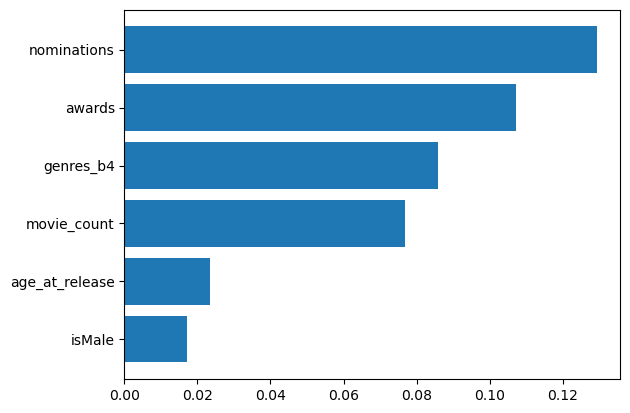

In [ ]:
correlation_matrix=actors_movies[[ 'awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release','averageRating']].corr()
correlation_with_X = correlation_matrix['averageRating'].drop('averageRating')  # Remove correlation with itself
correlation_with_X_sorted = correlation_with_X.sort_values()
# Create a horizontal bar plot
plt.barh(correlation_with_X_sorted.index, correlation_with_X_sorted)
plt.show()

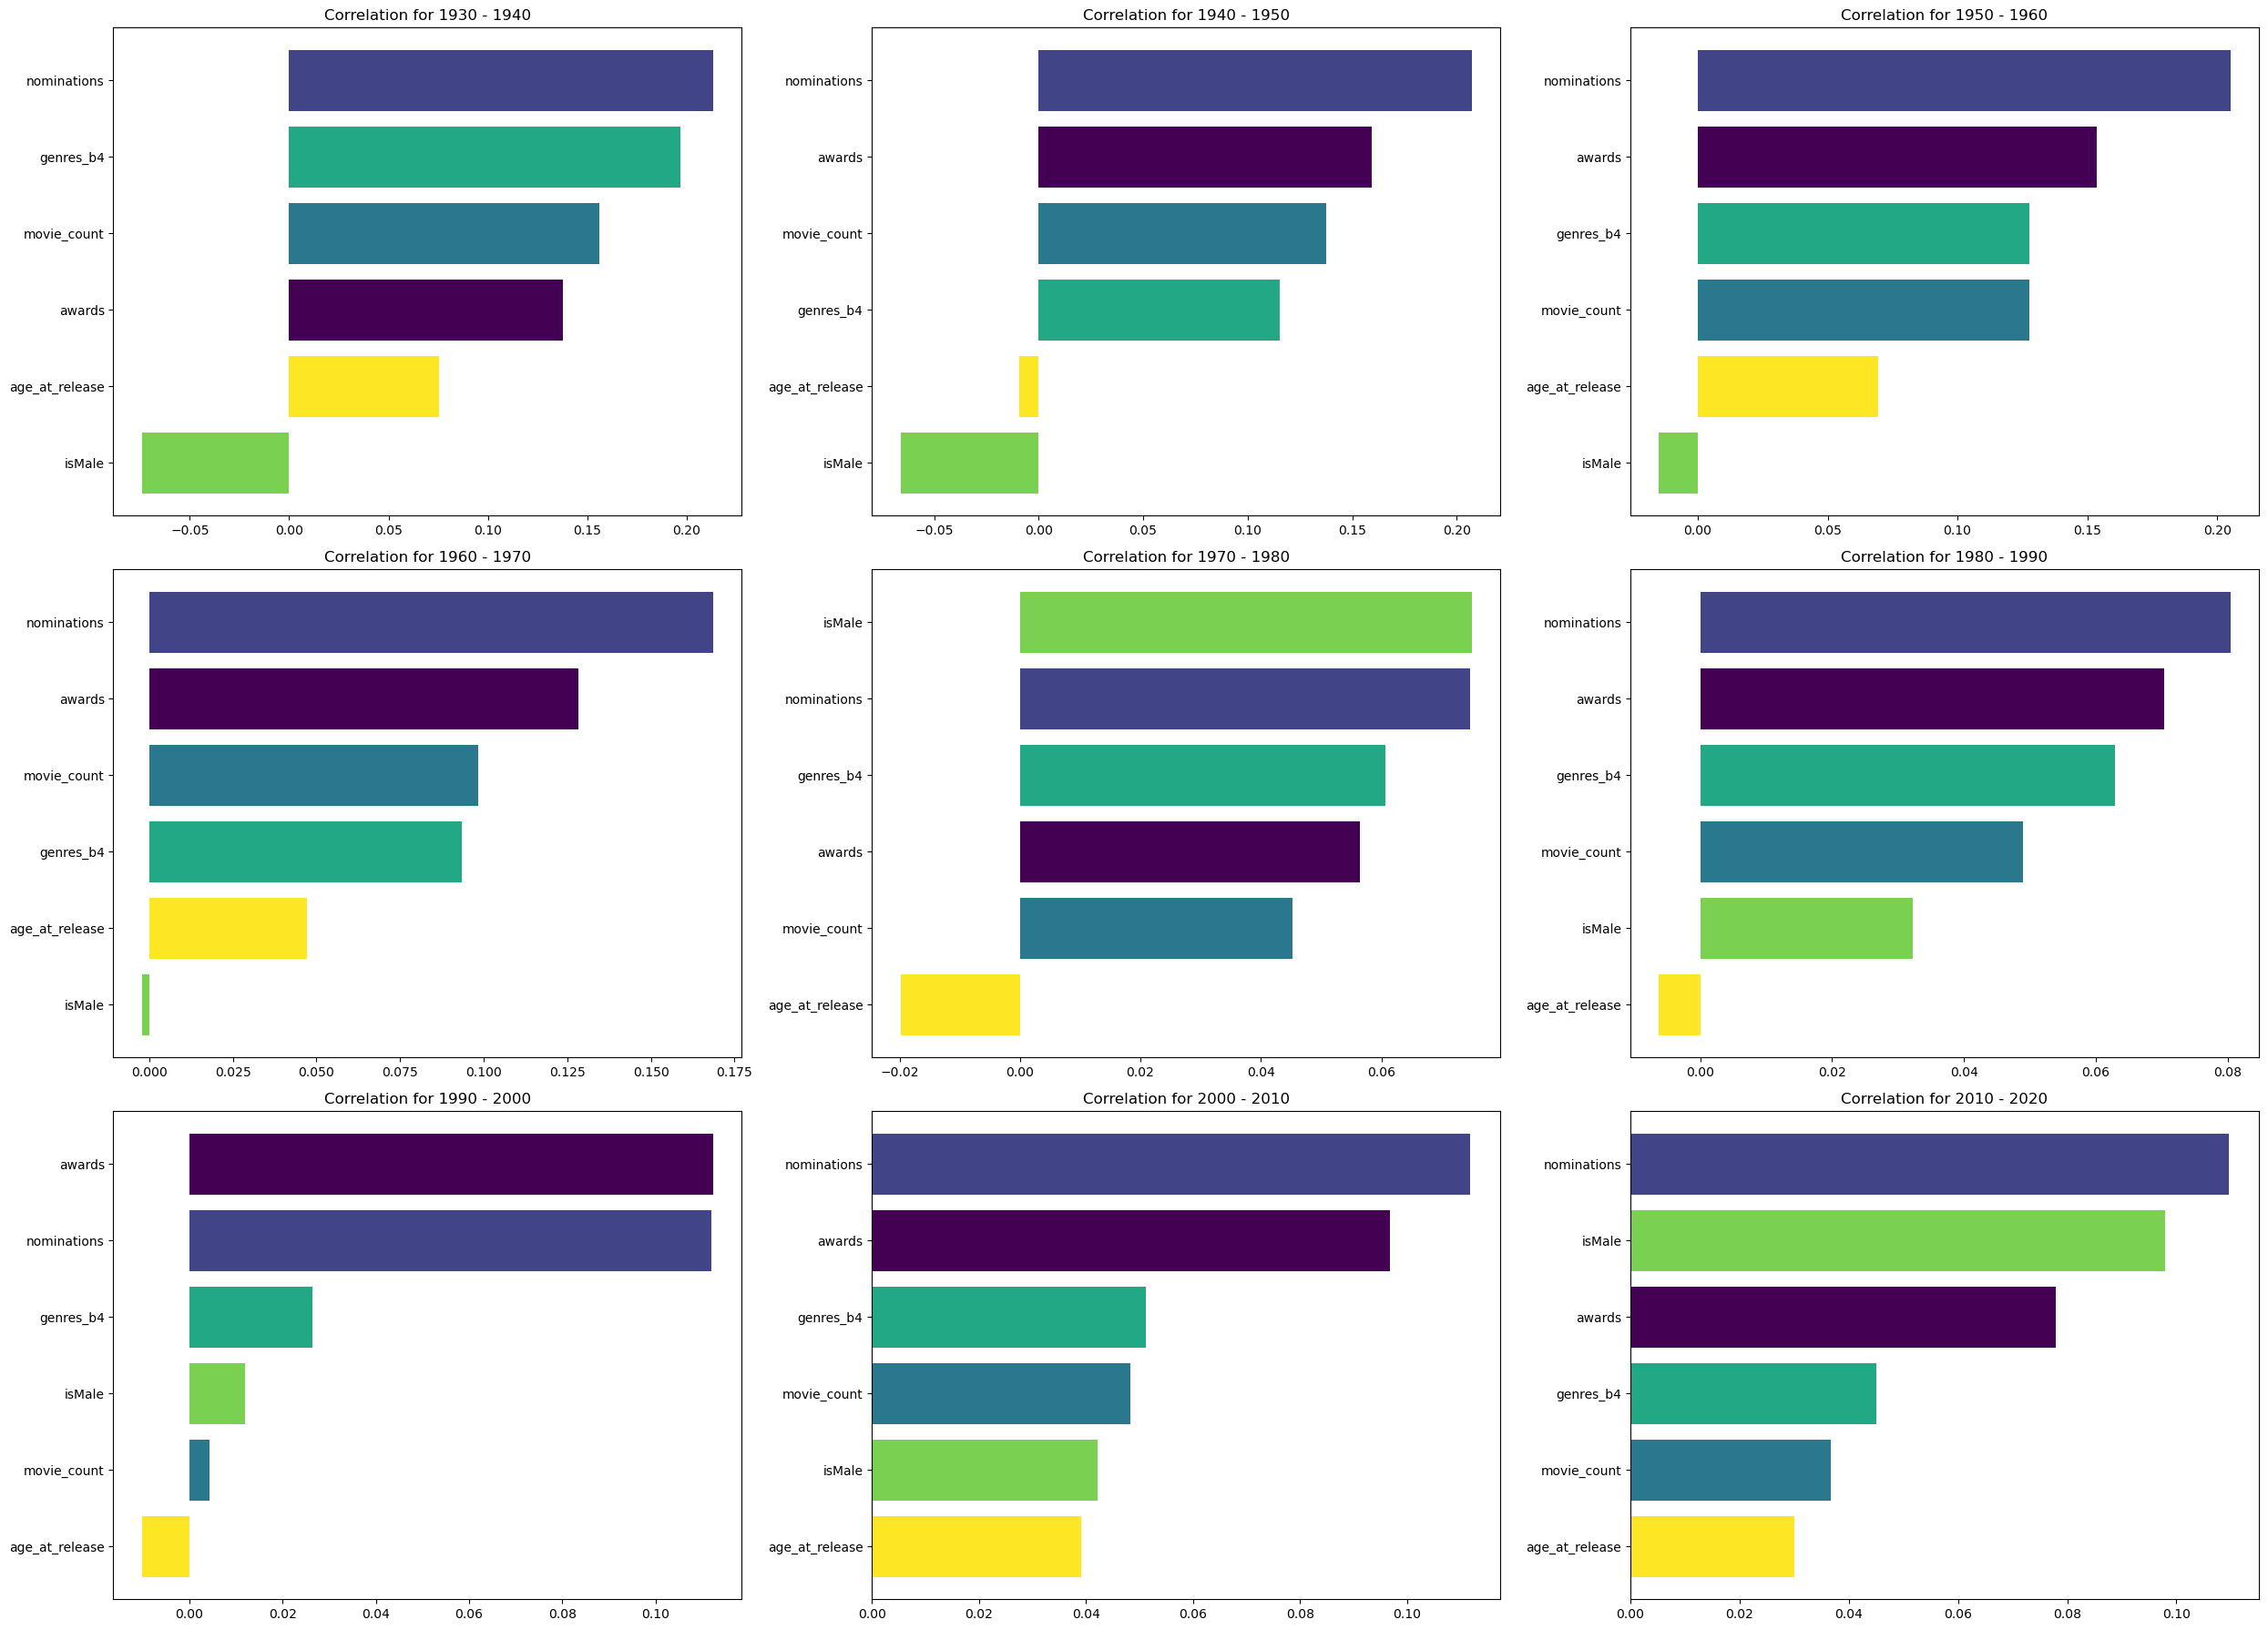

In [ ]:
figs, axs = plt.subplots(3, 3, figsize=(25, 18))
axs = axs.flatten()
Years = actors_movies['ReleaseYearRange'].unique()

# Define a colormap
cmap = plt.cm.viridis

# List of features
features = ['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release']

# Map each feature to a numerical value
feature_values = np.linspace(0, 1, len(features))
feature_colors = {feature: cmap(value) for feature, value in zip(features, feature_values)}

for i, year_range in enumerate(Years):
    Year = actors_movies[actors_movies['ReleaseYearRange'] == year_range]
    
    # Reset the index of Year to ensure alignment
    Year.reset_index(drop=True, inplace=True)

    correlation_matrix = Year[features + ['averageRating']].corr()
    correlation_with_X = correlation_matrix['averageRating'].drop('averageRating')
    correlation_with_X_sorted = correlation_with_X.sort_values()

    # Get colors for each feature
    colors = [feature_colors[feature] for feature in correlation_with_X_sorted.index]

    # Create a horizontal bar plot with specified colors
    axs[i].barh(correlation_with_X_sorted.index, correlation_with_X_sorted, color=colors)
    axs[i].set_title(f'Correlation for {year_range}')

plt.tight_layout()
plt.show()


<Axes: xlabel='awards', ylabel='averageRating'>

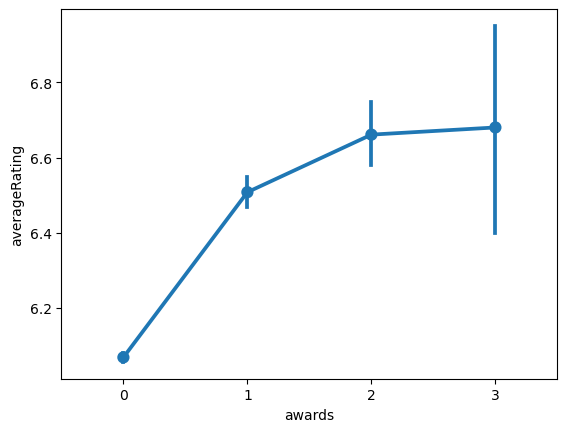

In [ ]:
sns.pointplot(x='awards', y='averageRating', data=actors_movies, errorbar=('ci', 95))

Even though there is a large confidence interval the higher the award count is, we can conclude that actors with oscars do infact play in betrter films.

<Axes: xlabel='nominations', ylabel='averageRating'>

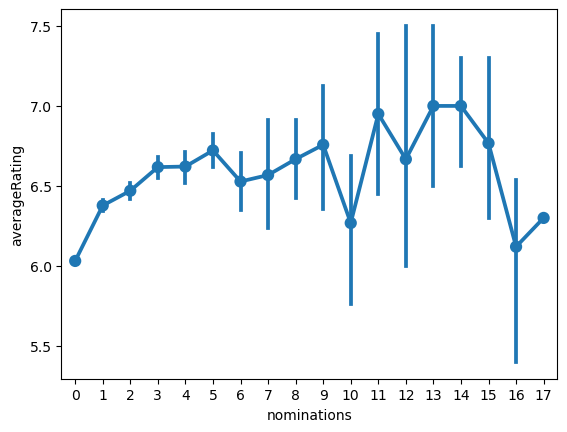

In [ ]:
sns.pointplot(x='nominations', y='averageRating', data=actors_movies, errorbar=('ci', 95))

In [ ]:
model = smf.glm(formula='averageRating ~ awards', data=actors_movies)
fit = model.fit()
print(fit.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                 Generalized Linear Model Regression Results                  
Dep. Variable:          averageRating   No. Observations:                28414
Model:                            GLM   Df Residuals:                    28412
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          1.1244
Method:                          IRLS   Log-Likelihood:                -41983.
Date:                Mon, 18 Dec 2023   Deviance:                       31947.
Time:                        15:09:13   Pearson chi2:                 3.19e+04
No. Iterations:                     3   Pseudo R-squ. (CS):            0.01154
Covariance Type:            nonrobust  

In [ ]:
actors_movies.reset_index(drop=True, inplace=True) #TODO Peut etre a changer

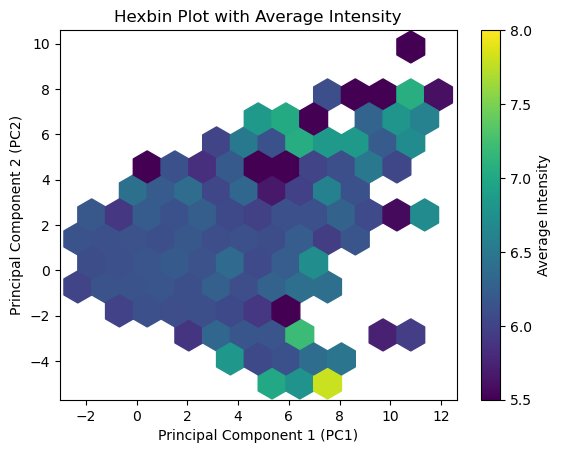

In [13]:
scaler = StandardScaler()
df_standardized = scaler.fit_transform(actors_movies[[ 'awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release','averageRating']].dropna())

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_standardized)

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['Rating'] = actors_movies[['averageRating']]

# Set custom vmin and vmax values
vmin = 5.5  # minimum value for the color scale
vmax = 8  # maximum value for the color scale

# Create a hexbin plot with average intensity
hexbin = plt.hexbin(df_pca['PC1'], df_pca['PC2'], C=df_pca['Rating'], gridsize=13, cmap='viridis', reduce_C_function=np.mean, vmin=vmin, vmax=vmax)
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('Hexbin Plot with Average Intensity')
plt.colorbar(hexbin, label='Average Intensity')
plt.show()

We can see that the right is a bit lighter than the left meaning that there is a difference in actors between good and bad films
#todo -> Same but with hue(+6.2, -6.2)

**PCA for all years**

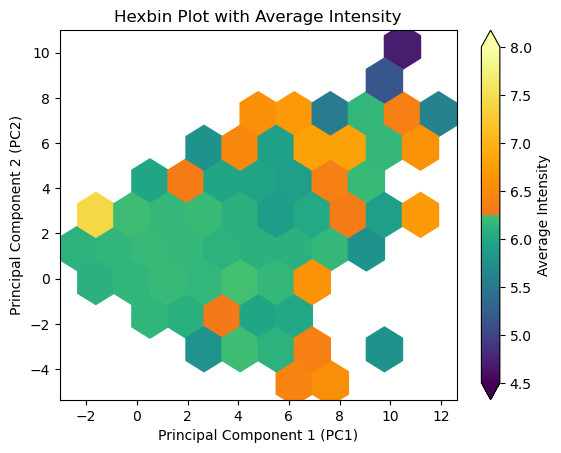

In [40]:
Years = actors_movies['ReleaseYearRange'].unique()
#Year40 = actors_movies[actors_movies['ReleaseYearRange'] == '1940 - 1950']
Year40 = actors_movies

 # Reset the index of Year to ensure alignment
Year40.reset_index(drop=True, inplace=True)

scaler = StandardScaler()
df_standardized = scaler.fit_transform(Year40[['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release']].dropna())

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_standardized)

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['Rating'] = actors_movies['averageRating']

# Set custom vmin and vmax values
vmin = 4.5  # minimum value for the color scale
vmax = 8    # maximum value for the color scale

# Create a custom colormap
colors_below_6_2 = plt.cm.viridis(np.linspace(0, 0.7, 256))
colors_above_6_2 = plt.cm.inferno(np.linspace(0.7, 1, 256))
colors_combined = np.vstack((colors_below_6_2, colors_above_6_2))
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors_combined)

# Create a hexbin plot with the custom colormap
hexbin = plt.hexbin(df_pca['PC1'], df_pca['PC2'], C=df_pca['Rating'], gridsize=10, cmap=custom_cmap, reduce_C_function=np.mean, vmin=vmin, vmax=vmax)
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('Hexbin Plot with Average Intensity')
plt.colorbar(hexbin, label='Average Intensity', extend='both')  # Add extend='both' to show color limits beyond the data range
plt.show()

In [17]:
Years = actors_movies['ReleaseYearRange'].unique()
Year40 = actors_movies[actors_movies['ReleaseYearRange'] == '1950 - 1960']


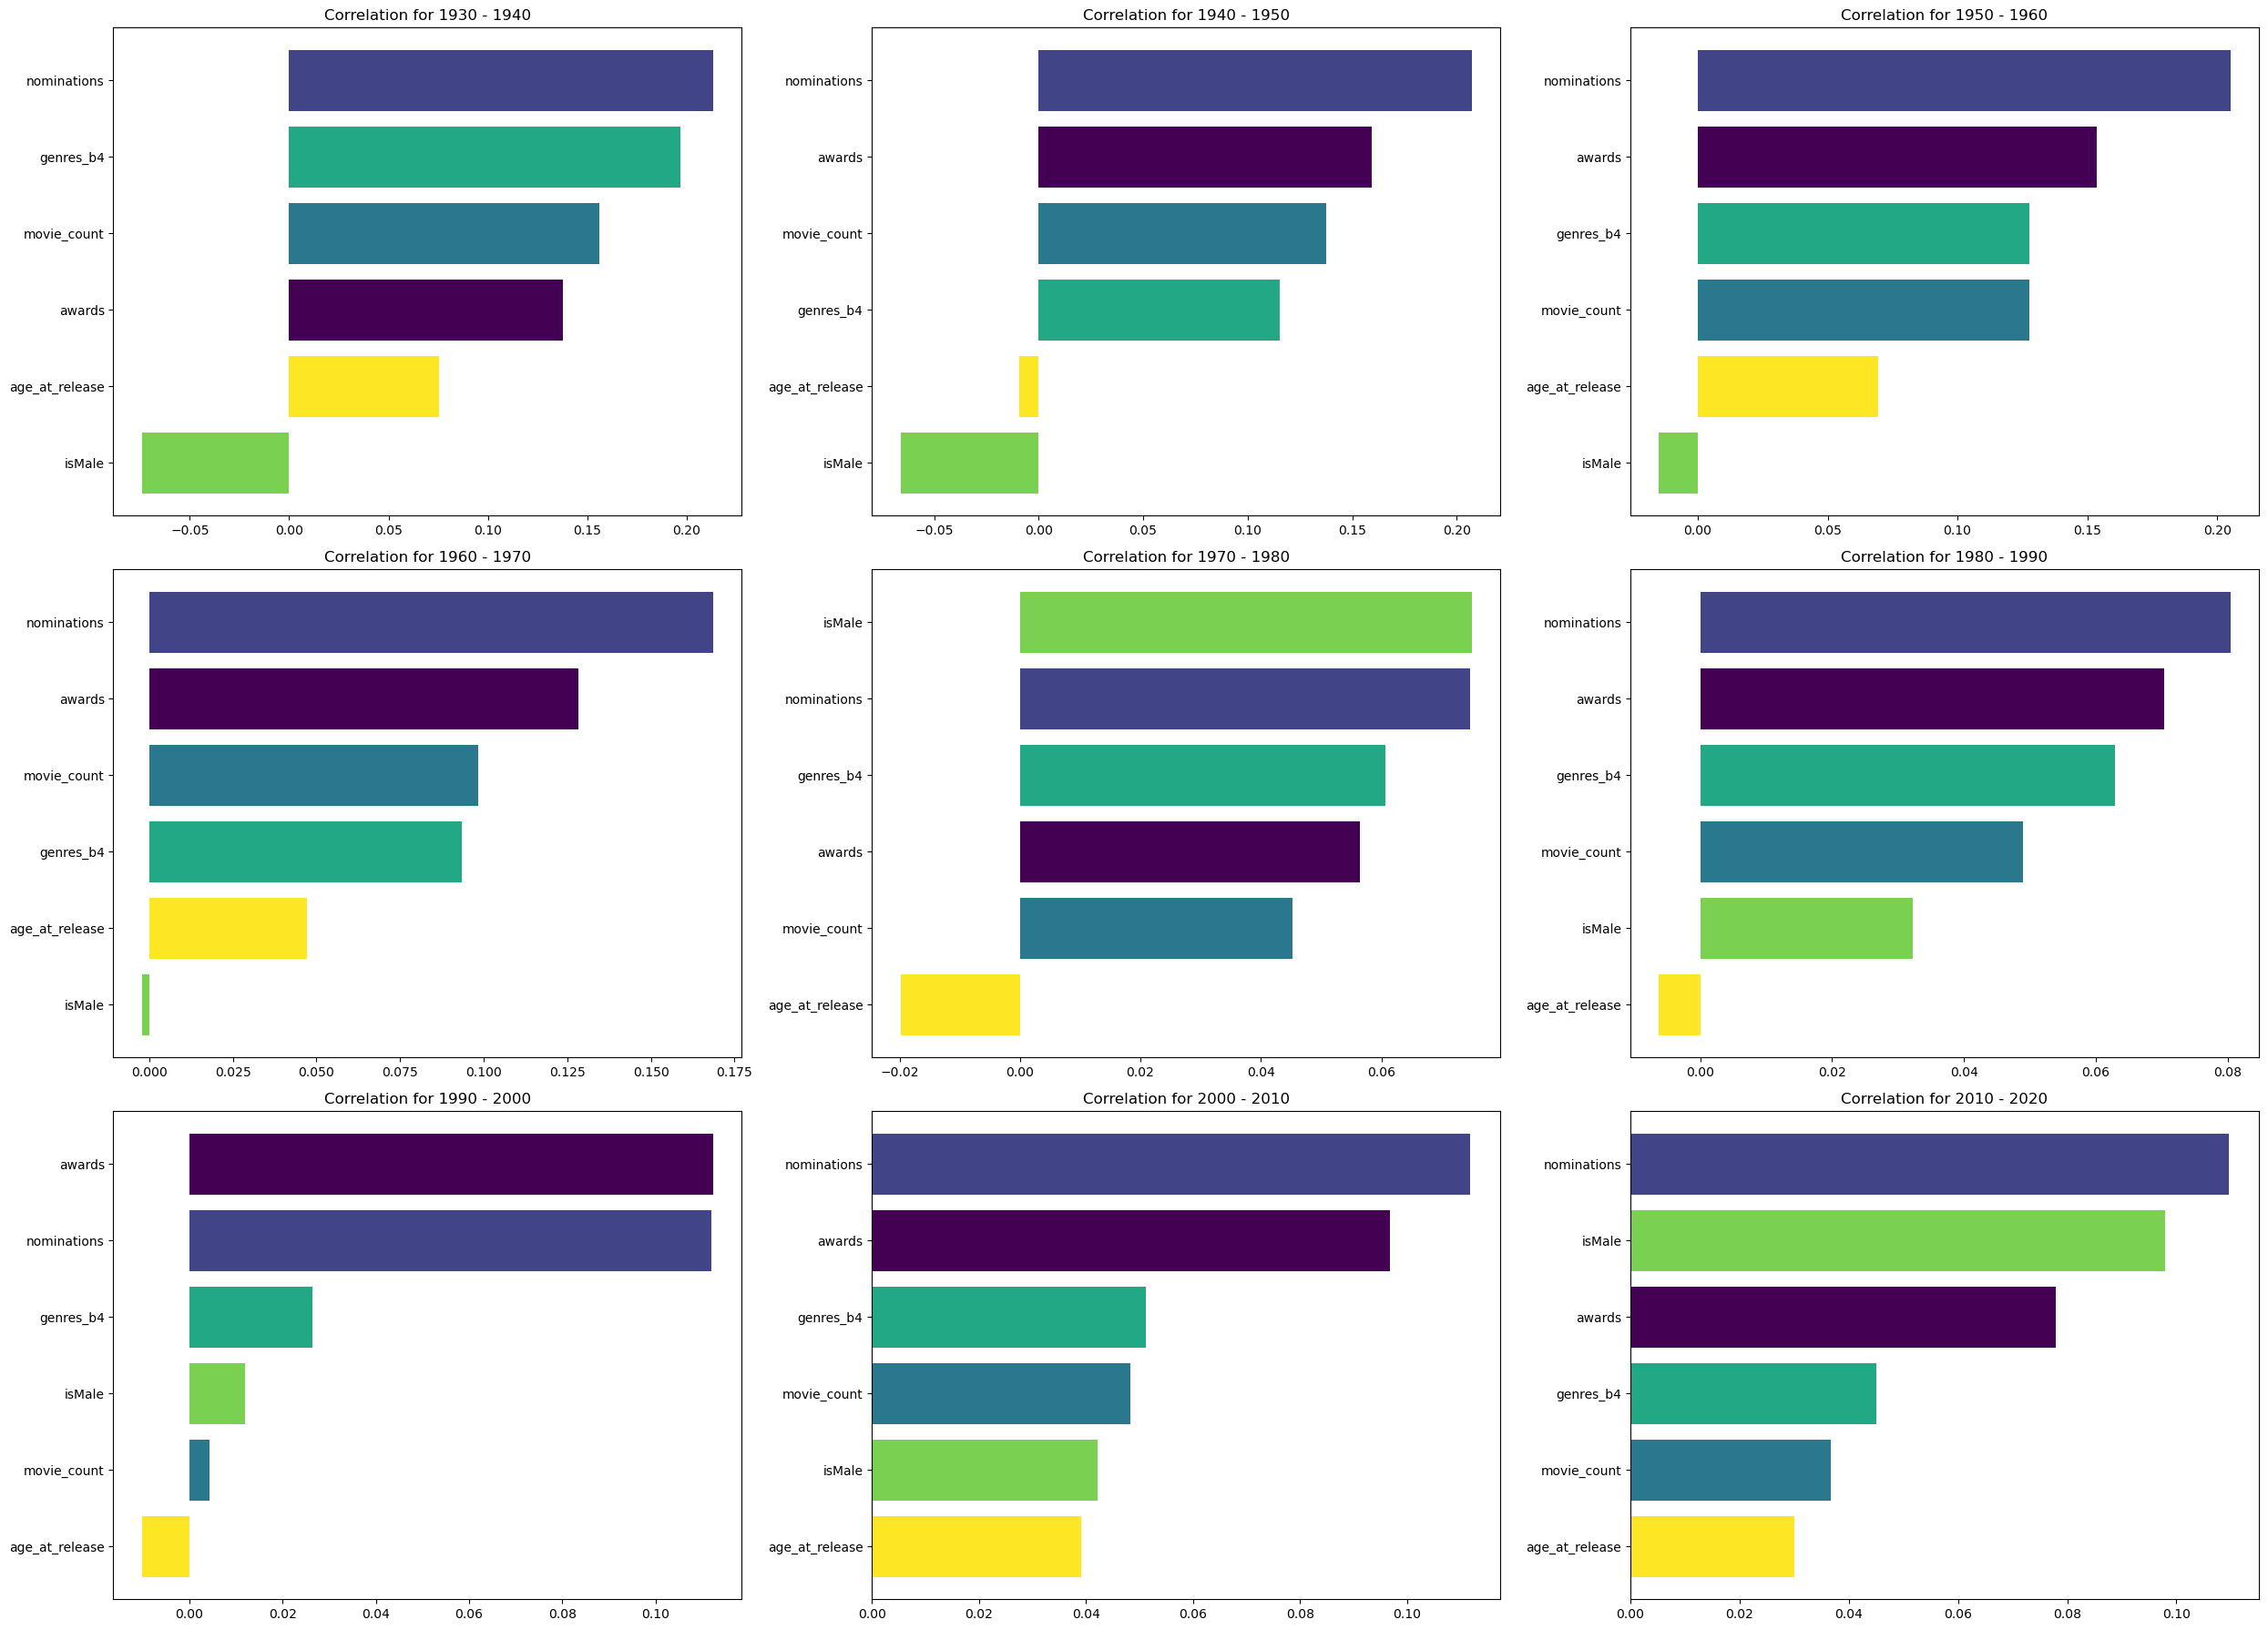

In [41]:
figs, axs = plt.subplots(3, 3, figsize=(25, 18))
axs = axs.flatten()
Years = actors_movies['ReleaseYearRange'].unique()

# Define a colormap
cmap = plt.cm.viridis

# List of features
features = ['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release']

# Map each feature to a numerical value
feature_values = np.linspace(0, 1, len(features))
feature_colors = {feature: cmap(value) for feature, value in zip(features, feature_values)}

for i, year_range in enumerate(Years):
    Year = actors_movies[actors_movies['ReleaseYearRange'] == year_range]
    
    # Reset the index of Year to ensure alignment
    Year.reset_index(drop=True, inplace=True)

    correlation_matrix = Year[features + ['averageRating']].corr()
    correlation_with_X = correlation_matrix['averageRating'].drop('averageRating')
    correlation_with_X_sorted = correlation_with_X.sort_values()

    # Get colors for each feature
    colors = [feature_colors[feature] for feature in correlation_with_X_sorted.index]

    # Create a horizontal bar plot with specified colors
    axs[i].barh(correlation_with_X_sorted.index, correlation_with_X_sorted, color=colors)
    axs[i].set_title(f'Correlation for {year_range}')

plt.tight_layout()
plt.show()

**PCA for each year on all features**

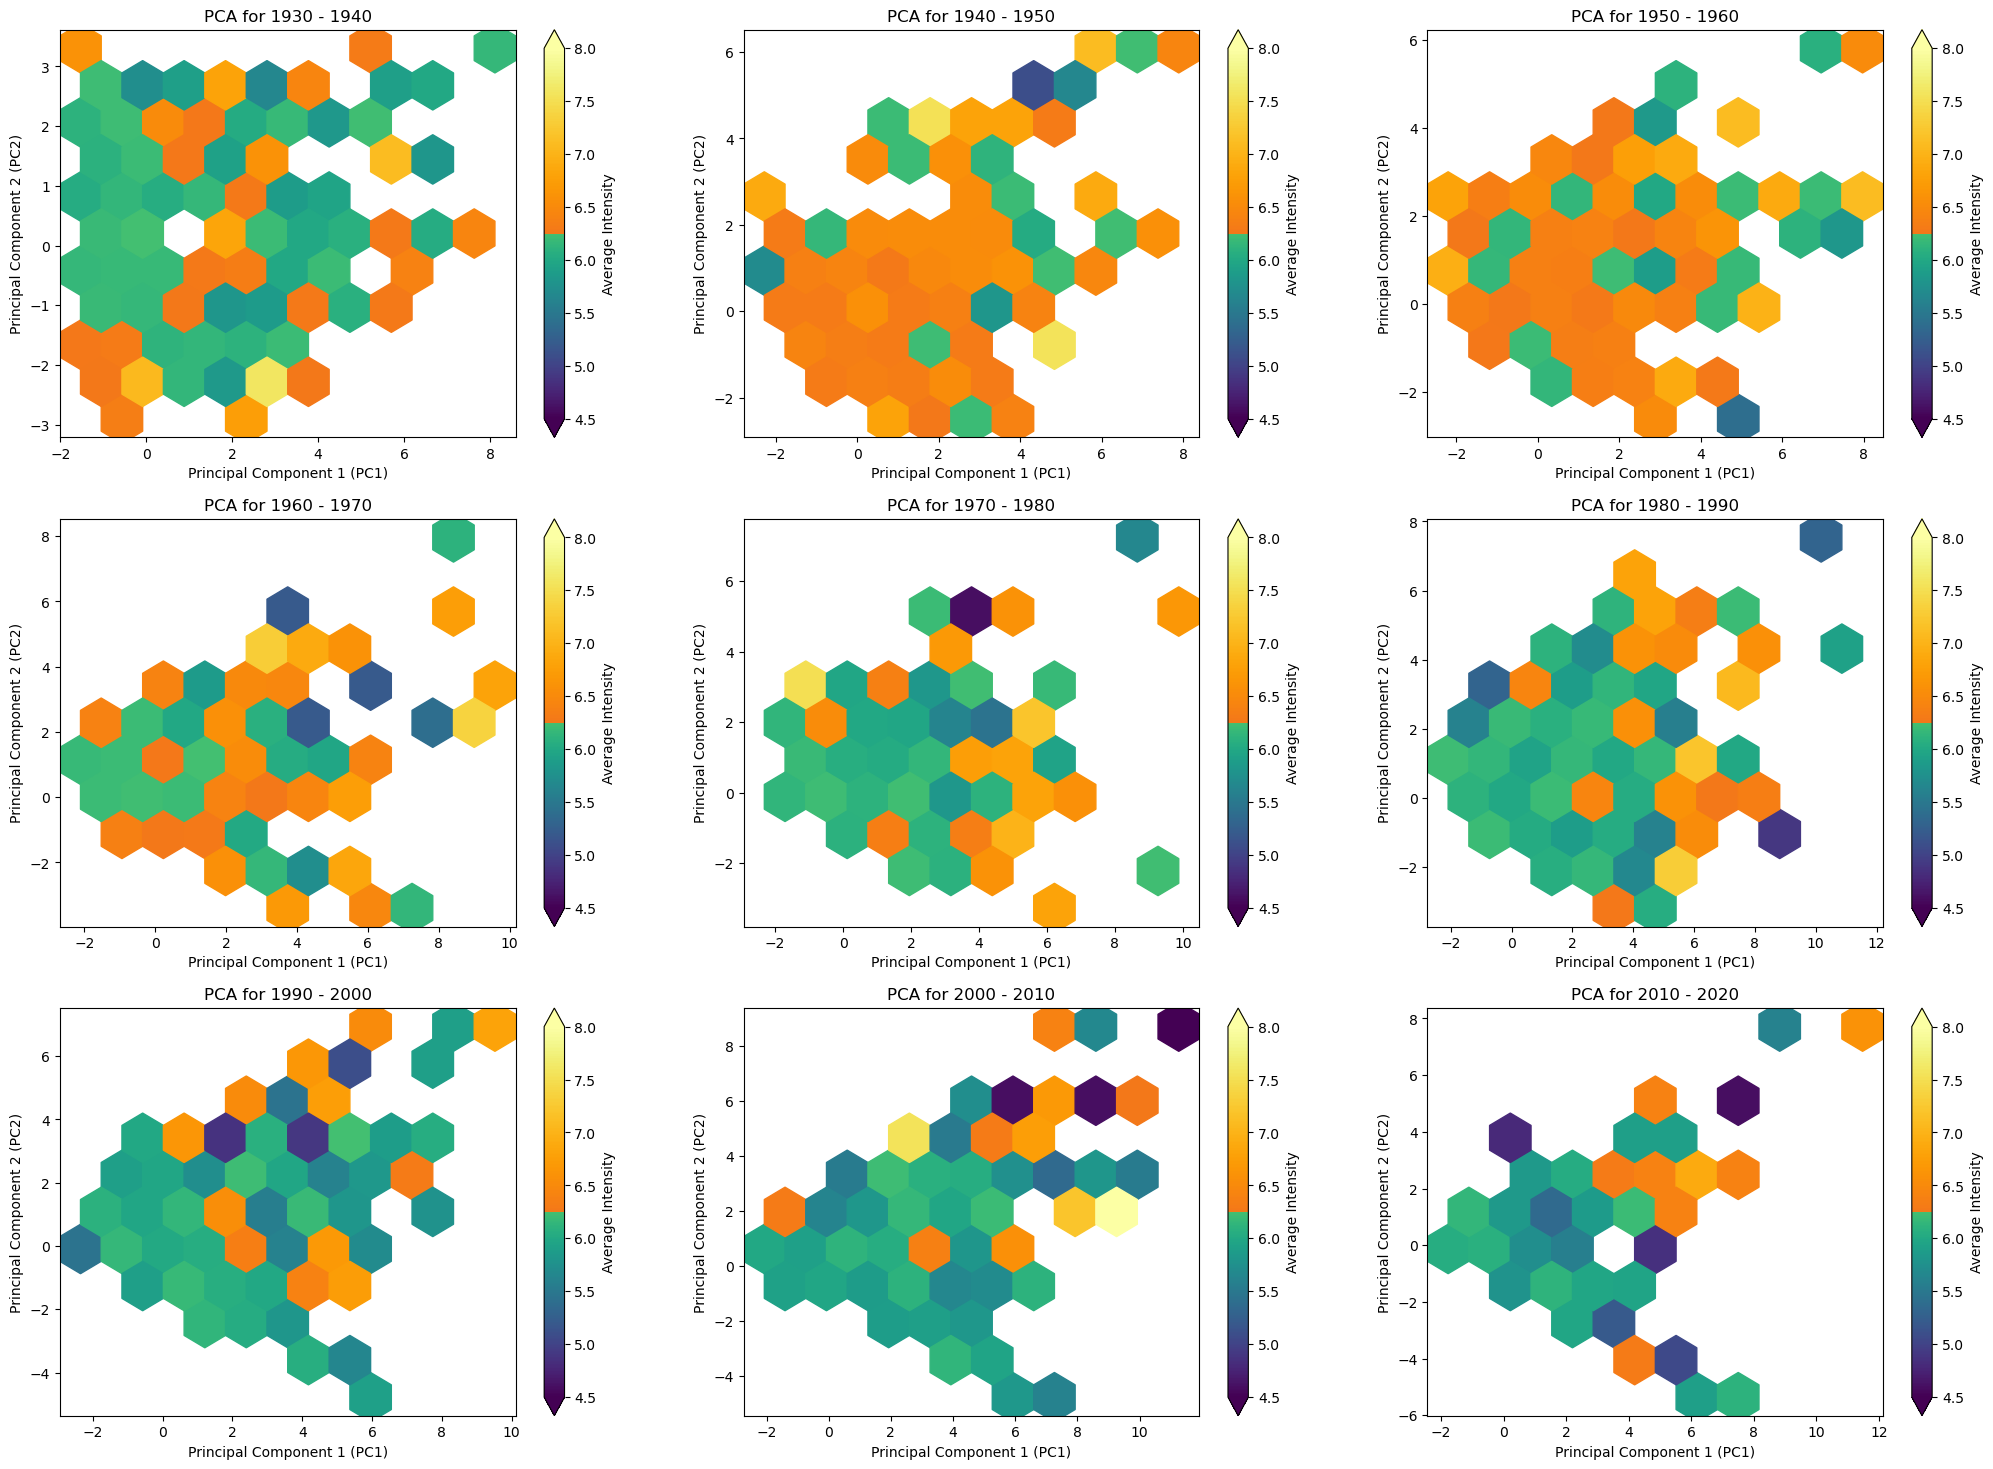

In [66]:
figs, axs = plt.subplots(3, 3, figsize=(25, 18))
axs = axs.flatten()
Years = actors_movies['ReleaseYearRange'].unique()

for i, year_range in enumerate(Years):
    Year = actors_movies[actors_movies['ReleaseYearRange'] == year_range]
    
    # Reset the index of Year to ensure alignment
    Year.reset_index(drop=True, inplace=True)

    scaler = StandardScaler()
    # Apply dropna() before scaling to ensure matching indices
    non_null_data = Year[['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release']].dropna()
    #non_null_data = Year[['awards', 'nominations', 'movie_count', 'genres_b4', 'age_at_release']].dropna()
    df_standardized = scaler.fit_transform(non_null_data)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_standardized)

    # Create a DataFrame with the PCA results
    df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    # Use non_null_data.index to ensure correct alignment of ratings
    df_pca['Rating'] = Year.loc[non_null_data.index, 'averageRating']
    
    # Set custom vmin and vmax values
    vmin = 4.5  # minimum value for the color scale
    vmax = 8    # maximum value for the color scale
    
    # Create a custom colormap
    colors_below_6_2 = plt.cm.viridis(np.linspace(0, 0.7, 256))
    colors_above_6_2 = plt.cm.inferno(np.linspace(0.7, 1, 256))
    colors_combined = np.vstack((colors_below_6_2, colors_above_6_2))
    custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors_combined)
    
    # Create a hexbin plot with the custom colormap
    hexbin = axs[i].hexbin(df_pca['PC1'], df_pca['PC2'], C=df_pca['Rating'], gridsize=10, cmap=custom_cmap, reduce_C_function=np.mean, vmin=vmin, vmax=vmax)


    axs[i].set_xlabel('Principal Component 1 (PC1)')
    axs[i].set_ylabel('Principal Component 2 (PC2)')
    axs[i].set_title(f'PCA for {year_range}')
    plt.colorbar(hexbin, label='Average Intensity', extend='both')

    
plt.show()

**PCA for each years, on features specific for each year (depends on the corr)**

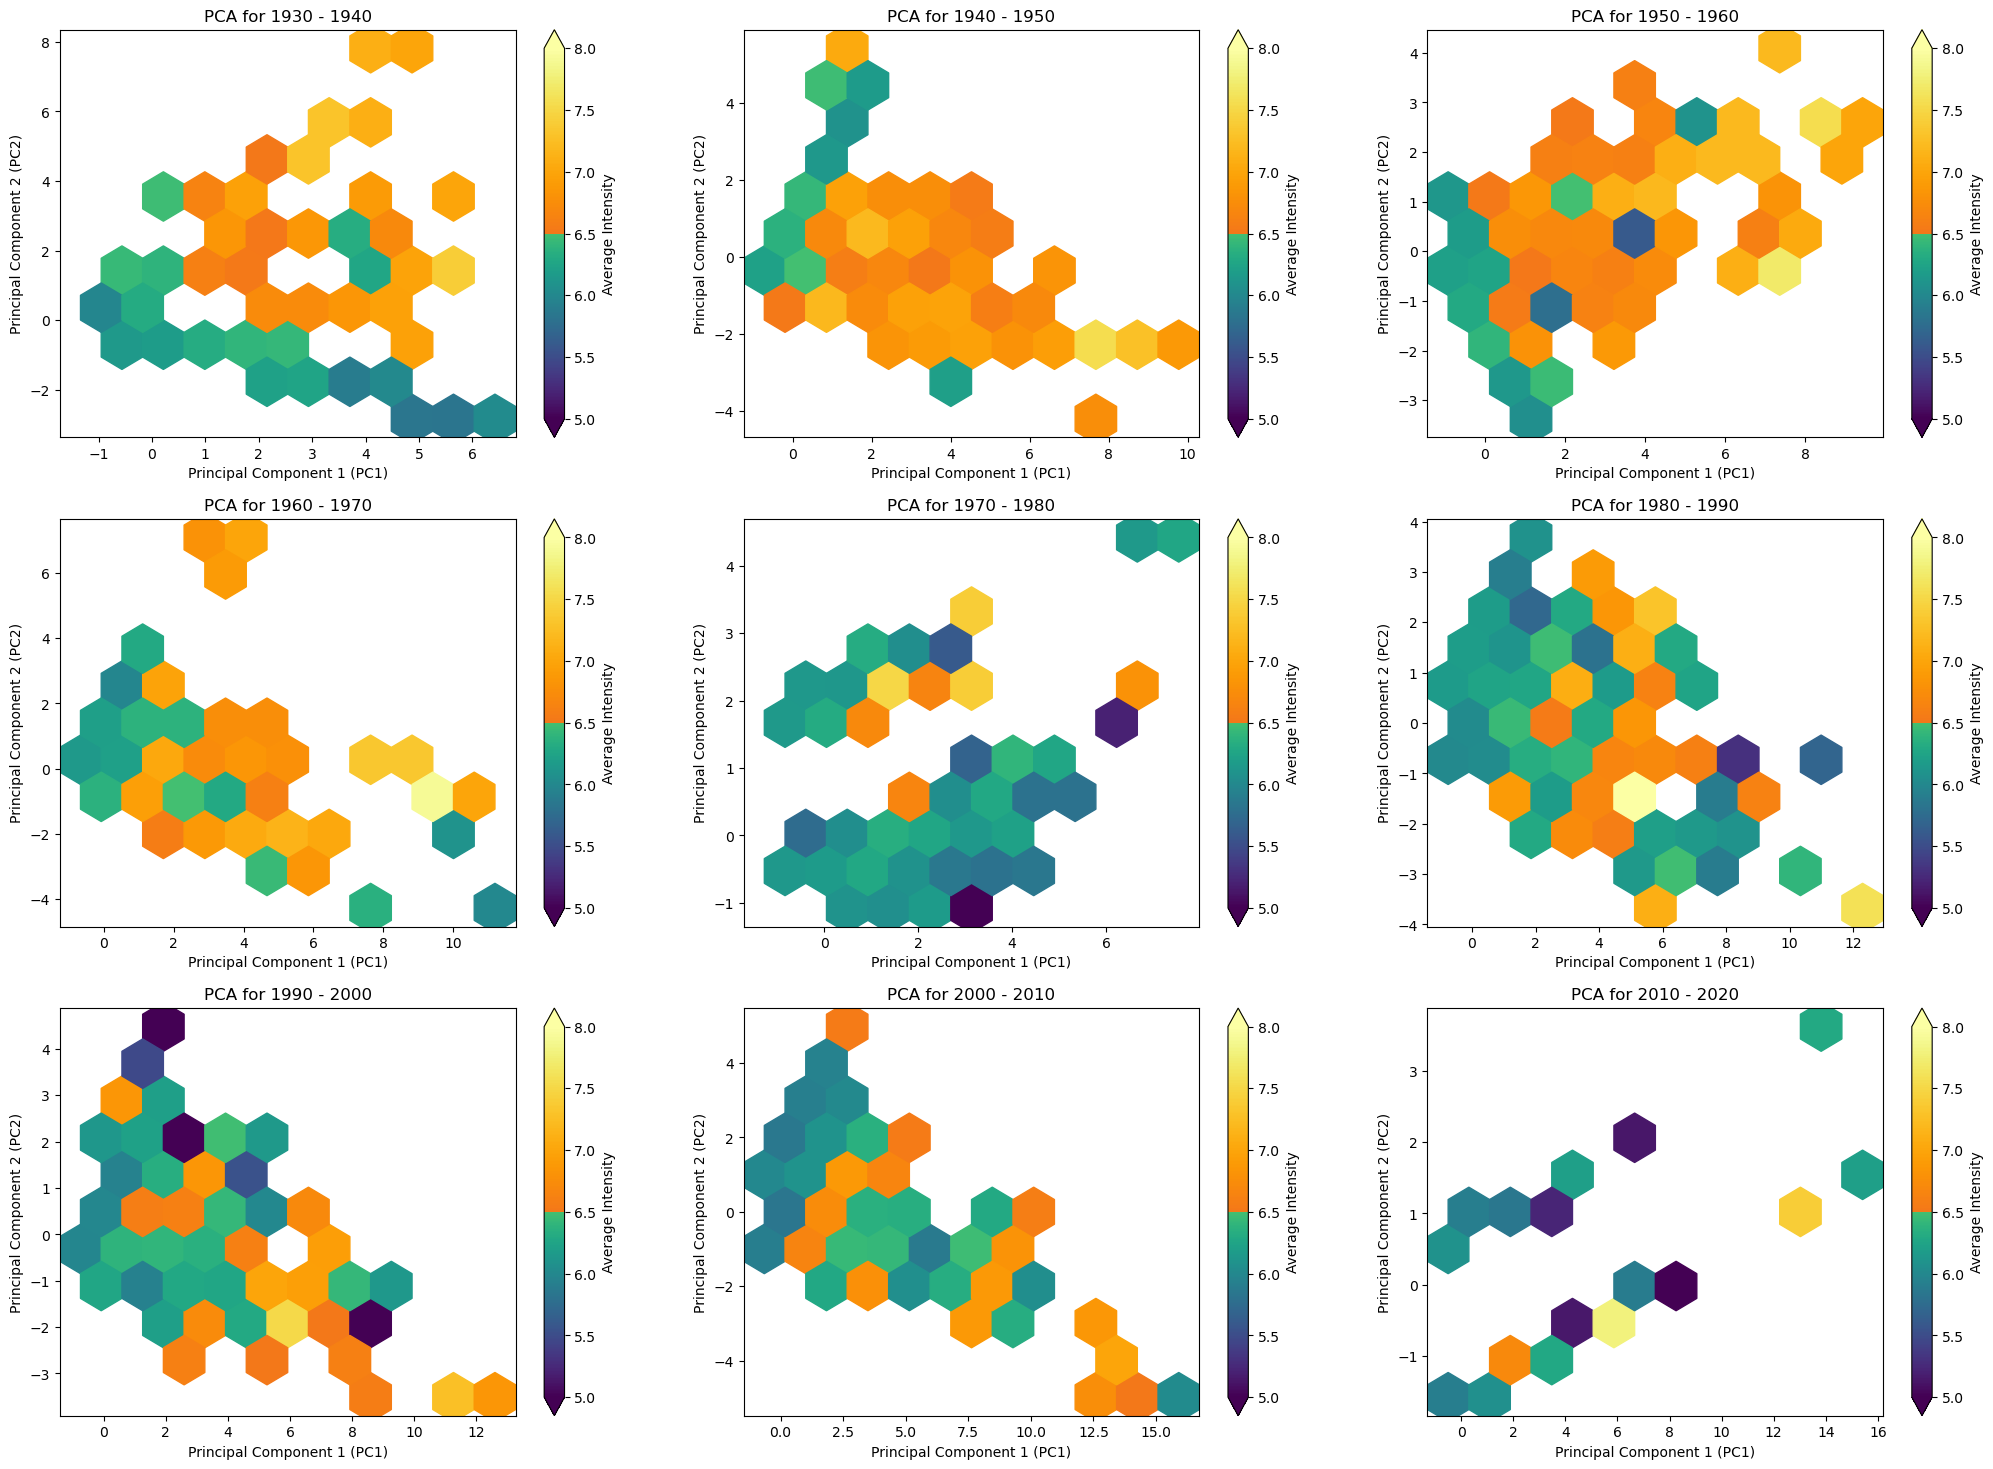

In [69]:
figs, axs = plt.subplots(3, 3, figsize=(25, 18))
axs = axs.flatten()
Years = actors_movies['ReleaseYearRange'].unique()

feature_groups = [
    ["nominations", "genres_b4", "movie_count",],  # 1930-1940
    ["nominations", "movie_count", "awards"],      # 1940-1950
    ["nominations", "genres_b4", "awards"],        # 1950-1960
    ["nominations", "movie_count", "awards"],      # 1960-1970
    ["isMale", "nominations", "genres_b4"],        # 1970-1980
    ["nominations", "genres_b4", "awards"],        # 1980-1990
    ["nominations", "genres_b4", "awards"],        # 1990-2000
    ["nominations", "genres_b4", "awards"],        # 2000-2010
    ["nominations", "isMale", "awards"]            # 2010-2020
]

for i, year_range in enumerate(Years):
    Year = actors_movies[actors_movies['ReleaseYearRange'] == year_range]
    
    # Reset the index of Year to ensure alignment
    Year.reset_index(drop=True, inplace=True)

    scaler = StandardScaler()
    # Apply dropna() before scaling to ensure matching indices
    non_null_data = Year[feature_groups[i]].dropna()
    #non_null_data = Year[['awards', 'nominations', 'movie_count', 'genres_b4', 'age_at_release']].dropna()
    df_standardized = scaler.fit_transform(non_null_data)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_standardized)

    # Create a DataFrame with the PCA results
    df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    # Use non_null_data.index to ensure correct alignment of ratings
    df_pca['Rating'] = Year.loc[non_null_data.index, 'averageRating']
    
    # Set custom vmin and vmax values
    vmin = 5  # minimum value for the color scale
    vmax = 8    # maximum value for the color scale
    
    # Create a custom colormap
    colors_below_6_2 = plt.cm.viridis(np.linspace(0, 0.7, 256))
    colors_above_6_2 = plt.cm.inferno(np.linspace(0.7, 1, 256))
    colors_combined = np.vstack((colors_below_6_2, colors_above_6_2))
    custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors_combined)
    
    # Create a hexbin plot with the custom colormap
    hexbin = axs[i].hexbin(df_pca['PC1'], df_pca['PC2'], C=df_pca['Rating'], gridsize=10, cmap=custom_cmap, reduce_C_function=np.mean, vmin=vmin, vmax=vmax)


    axs[i].set_xlabel('Principal Component 1 (PC1)')
    axs[i].set_ylabel('Principal Component 2 (PC2)')
    axs[i].set_title(f'PCA for {year_range}')
    plt.colorbar(hexbin, label='Average Intensity', extend='both')

plt.show()